In [55]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

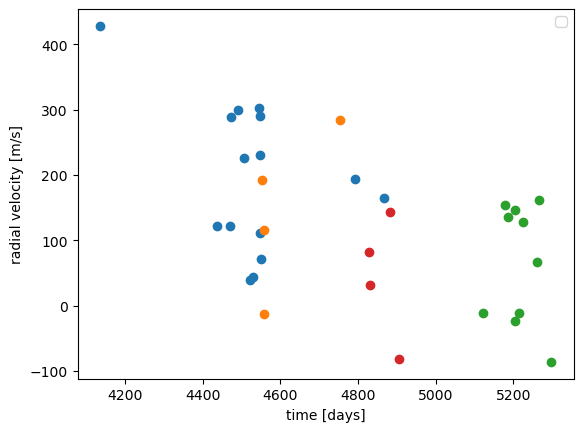

In [69]:
data = pd.read_table('hpf.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])

neid_he = pd.read_table('neidhe.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
neid_hr = pd.read_table('neidhr.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
time = (data['time'] - 2454833).values 
# rad_vel = data['radial_velocity'].values
# rv_err = data['rv_error'].values

neidhe_time = (neid_he['time'] - 2454833).values 
neidhe_rad_vel = neid_he['radial_velocity'].values
neidhe_rv_err = neid_he['rv_error'].values

neidhr_time = (neid_hr['time'] - 2454833).values 
neidhr_rad_vel = neid_hr['radial_velocity'].values
neidhr_rv_err = neid_hr['rv_error'].values

time = pd.concat([data['time'], neid_he['time'], neid_hr['time']])

merged_data = pd.concat([data, neid_he, neid_hr], axis = 0).reset_index(drop=True)
time = (merged_data['time'] - 2454833).values 
rad_vel = merged_data['radial_velocity'].values
rv_err = merged_data['rv_error'].values
instrument = merged_data['instrument'].values

# # Compute a reference time that will be used to normalize the trends model
time_ref = 0.5 * (time.min() + time.max())


# # Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(time.min() - 5, time.max() + 5, 1000)



for n_instrument in np.unique(instrument):
    cull = instrument == n_instrument
    plt.plot(time[cull], rad_vel[cull], linestyle = 'none', marker = 'o')

plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.legend()

In [70]:
periods = [6.7252337648, 1000]
period_errs = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_errs = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = True

noline = True

Ks = xo.estimate_semi_amplitude(periods, time, rad_vel, rv_err, t0s=t0s)
#print("The semi-amplitudes:",Ks, "m/s")

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value



with pm.Model() as model:
    
    mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar Parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*R_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
    m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
    # deterministic means values that were derived from the model
    density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3
    
    # Wide log-normal prior for semi-amplitude
    K = pm.Uniform(
        "K", lower = 1, upper = 1000, shape = nplanets)
    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_errs), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_errs), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    #Jitter & a baseline for now RV trend 
    #each instrument will have its own rv offset aka trend
    RVOffset = pm.Normal("RVOffset",
                         mu=np.array([0]*len(merged_data.instrument.unique())), 
                         sigma=20000, 
                         shape=len(merged_data.instrument.unique()),) #offset relative to each instrument
    
    RVJitter = pm.Uniform("RVJitter", 1e-3,1e3, shape=len(merged_data.instrument.unique())) #adding additional noise
    
    RVMean = tt.zeros(merged_data.shape[0])
    RVError = tt.zeros(merged_data.shape[0])
    
    for i, inst in enumerate(merged_data.instrument.unique()):
        RVMean += RVOffset[i] * (merged_data.instrument == inst)
        RVError += tt.sqrt(rv_err**2 + RVJitter[i]**2) * (merged_data.instrument == inst)
        
    pm.Deterministic("RVMean", RVMean)
    pm.Deterministic("RVError", RVError)
    # Orbit Model
    orbit = xo.orbits.KeplerianOrbit(r_star = R_star, m_star= M_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega, 
                                     m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
#     orbit = xo.orbits.KeplerianOrbit(period = P, t0=t0, ecc=ecc, omega=omega)
    
    
    # A function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K = K) 
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
#         A = np.vander(t - time_ref, trendshape)
#         bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))
    
    # Define the RVs at the observed times
    rv_model = get_rv_model(time)
#     rv_model2 = get_rv_model(neidhe_time)
#     rv_model3 = get_rv_model(neidhr_time)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model

#     err = tt.sqrt(rv_err**2 + tt.exp(2 * logs))

    pm.Normal("obs", mu = rv_model, sd = RVError, observed = rad_vel - RVMean)
    
#     err2 = tt.sqrt(neidhe_rv_err**2 + tt.exp(2 * logs2))
#     pm.Normal("obs2", mu = rv_model2, sd = err2, observed = neidhe_rad_vel)
    
#     err3 = tt.sqrt(neidhr_rv_err**2 + tt.exp(2 * logs3))
#     pm.Normal("obs3", mu = rv_model3, sd = err3, observed = neidhr_rad_vel)

    #Optimize to find MAP
    map_soln = model.test_point
    print(model.check_test_point())
    map_soln = pmx.optimize(map_soln, [RVJitter, RVOffset, K])
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)
    map_soln = pmx.optimize(map_soln)    


mean                        -1.42
u_quadlimbdark__            -2.77
m_star_interval__           -1.12
r_star_interval__            0.01
teff_interval__             -7.10
ror_interval__              -2.77
m_pl_interval__            -20.83
K_interval__                -2.77
period                      -5.75
t0                           2.77
b_interval__                -2.77
ecs_unitdisk+interval__     -2.82
RVOffset                   -43.29
RVJitter_interval__         -5.55
obs                       -257.55
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [K, RVOffset, RVJitter]


message: Optimization terminated successfully.
logp: -353.73363497317496 -> -269.916057648171
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -269.916057648171 -> -267.73751588260916
optimizing logp for variables: [RVJitter, RVOffset, ecs, b, t0, period, K, m_pl, ror, teff, r_star, m_star, u, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -267.73751588260916 -> -227.86784089925533


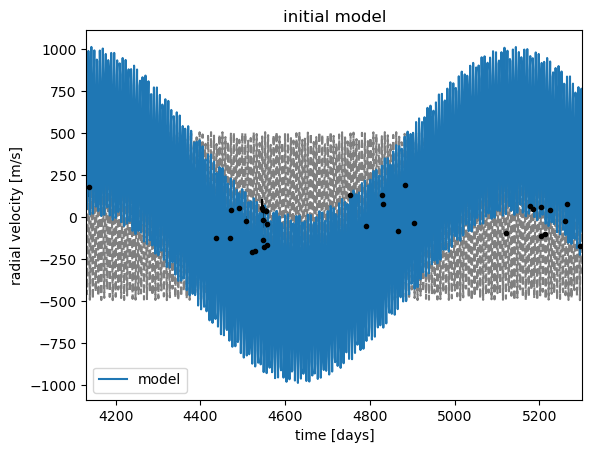

In [71]:
plt.errorbar(time, rad_vel-map_soln['RVMean'], yerr = rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha= 0.5)
#     plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5, zorder = 100)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred),label="model")


plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(4550,4560)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [72]:
### Eccentric Fit ###
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))

*** MAP Fit Parameters ***
mean: 5.621550819867014e-08
period: [  6.72548174 882.69704515]
t0: [2388.84458406 3380.82222904]
RVOffset: [247.34346401 153.81086785 -49.84771734  85.3384576 ]
u: [0.70710678 0.        ]
m_star: 0.8197747702972784
r_star: 0.789943028400381
teff: 4869.065040020888
st_lum: 0.3148939917390332
ror: [0.5 0.5]
r_pl: [0.395 0.01 ]
m_pl: [15000.05061366 15000.05061366]
density_pl: [1.03413244e+00 6.37334530e+04]
K: [124.33153996  78.11201174]
b: [0.5 0.5]
ecs: [[-0.12957036  0.0076336 ]
 [-0.14850062  0.57737434]]
ecc: [0.03884091 0.33341939]
omega: [-2.28822228  1.55757586]
RVJitter: [14.7306298  10.32015455 26.10097466  8.11136598]
RVMean: [247.34346401 247.34346401 247.34346401 247.34346401 247.34346401
 247.34346401 247.34346401 247.34346401 247.34346401 247.34346401
 247.34346401 247.34346401 247.34346401 247.34346401 247.34346401
 153.81086785 153.81086785 153.81086785 153.81086785 -49.84771734
 -49.84771734 -49.84771734 -49.84771734  85.3384576   85.3384576


In [74]:
## Samples The Posterior Defined By The Model ###
NSteps = 1000
Nchains = 4
Ncores = 5
with model:

    trace = pmx.sample(
        tune=NSteps,
        draws= int(NSteps/2),
        start=map_soln,
        cores = Ncores,
        chains = Nchains,
        target_accept=0.95,
        return_inferencedata=True,
    )
# with model:
#     trace = pmx.sample(
#         tune=1000,
#         draws=1000,
#         cores=2,
#         chains=5,
#         target_accept=0.9,
#         return_inferencedata=True,
#     )

Multiprocess sampling (4 chains in 5 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 5 jobs)
NUTS: [RVJitter, RVOffset, ecs, b, t0, period, K, m_pl, ror, teff, r_star, m_star, u, mean]
INFO:pymc3:NUTS: [RVJitter, RVOffset, ecs, b, t0, period, K, m_pl, ror, teff, r_star, m_star, u, mean]


/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/tuca/Documents/EPIC/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 13 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 13 seconds.
There were 17 divergences after tuning. Increase `target_accept` or r

In [75]:
### Eccentric Fit ###

import arviz as az

az.summary(trace, var_names=["RVJitter", "RVOffset","period", "K", "t0", "ecc", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
RVJitter[0],13.499,10.703,0.015,33.094,0.248,0.175,1340.0,856.0,1.00
RVJitter[1],49.112,67.334,0.012,135.137,4.663,3.478,487.0,287.0,1.01
RVJitter[2],63.900,86.609,0.029,178.953,6.380,4.598,490.0,242.0,1.01
RVJitter[3],23.501,13.174,0.074,44.450,0.497,0.352,606.0,491.0,1.01
RVOffset[0],241.681,17.882,208.054,276.531,0.742,0.525,601.0,602.0,1.01
RVOffset[1],159.879,48.781,93.369,240.851,3.508,2.484,469.0,250.0,1.01
RVOffset[2],-34.538,63.944,-132.074,47.714,5.336,3.941,442.0,181.0,1.01
RVOffset[3],47.305,32.129,-13.325,104.231,1.420,1.004,543.0,762.0,1.00
period[0],6.725,0.001,6.724,6.726,0.000,0.000,1021.0,978.0,1.01
period[1],891.574,61.307,778.990,1030.274,6.619,4.697,178.0,52.0,1.02


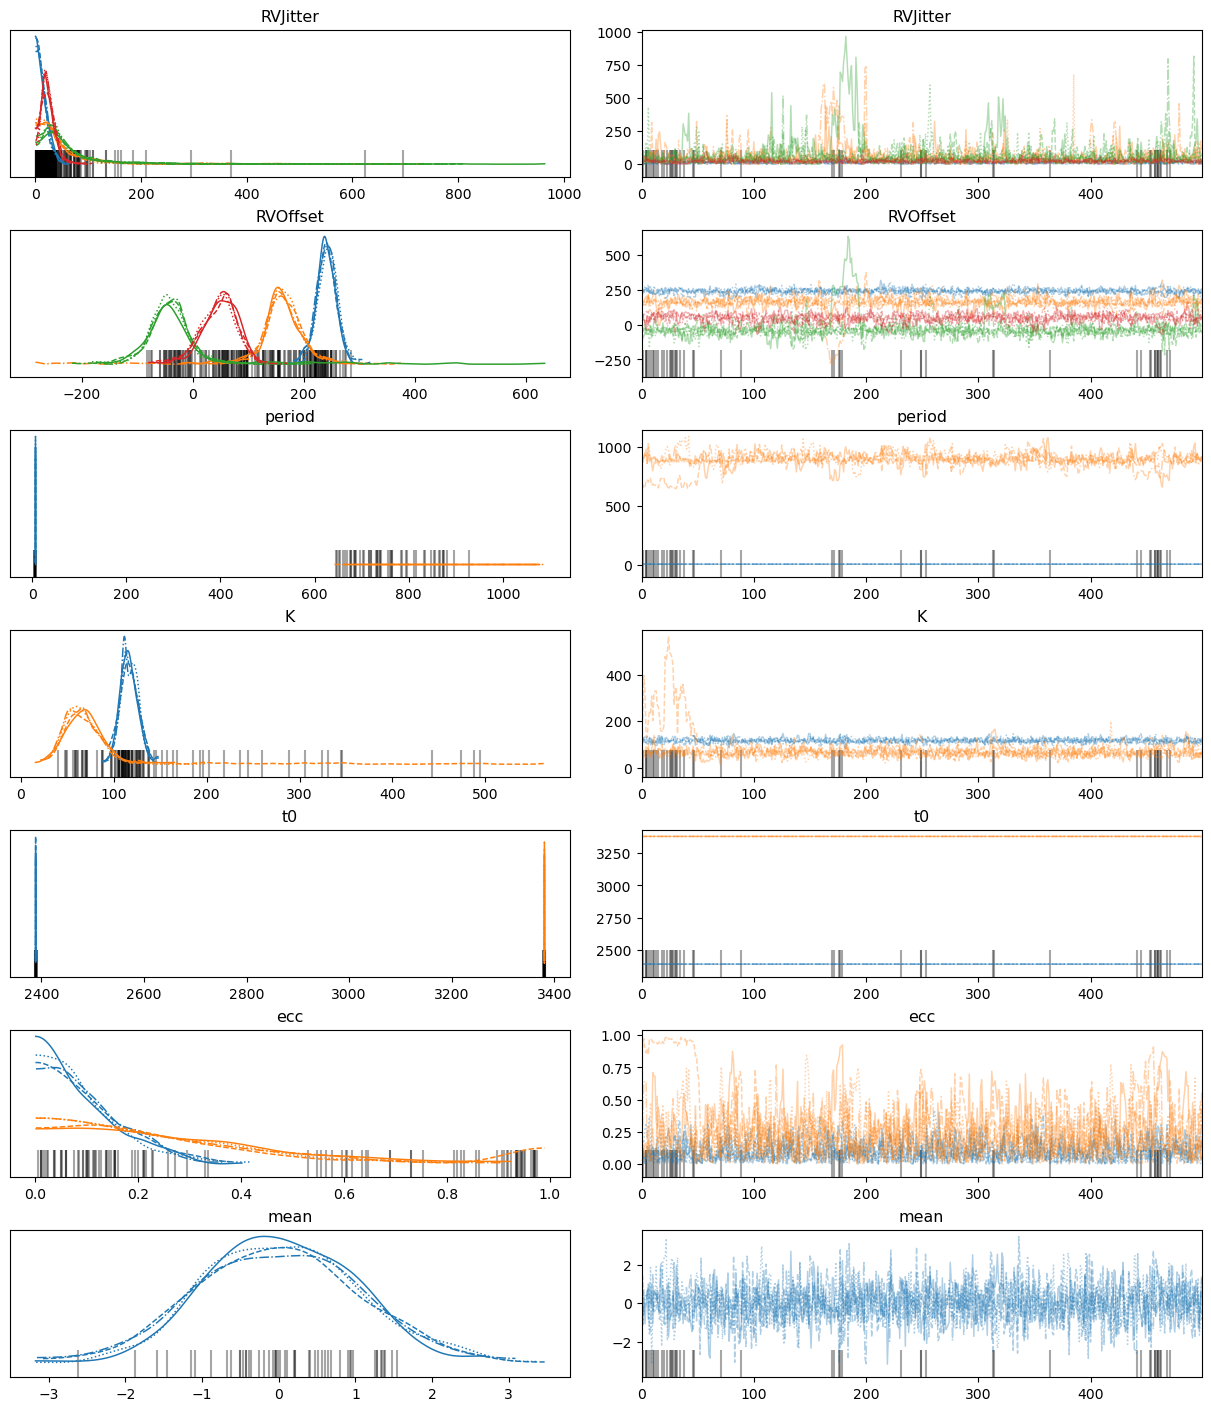

In [76]:
_ = az.plot_trace(trace, var_names=["RVJitter", "RVOffset","period", "K", "t0", "ecc", "mean"])

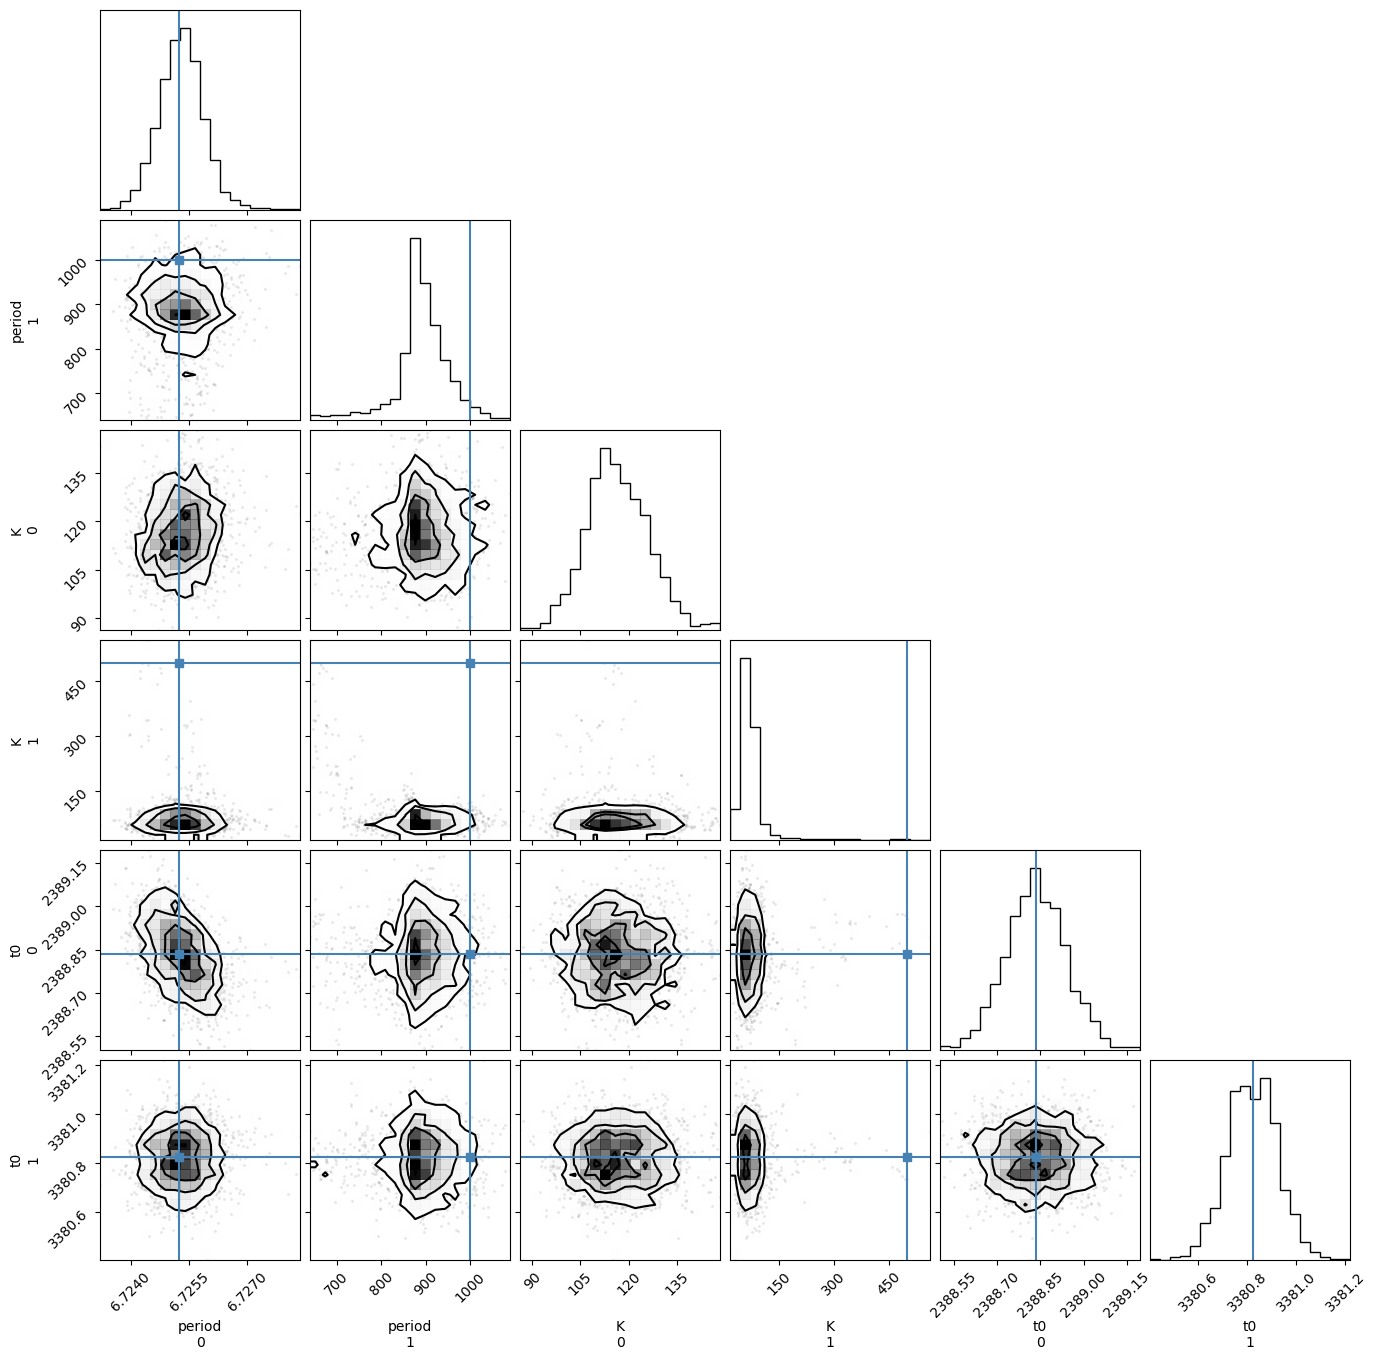

In [77]:
### Corner Plot For Parameters of Interest ###

import corner

# truth = dict(
#     zip(
#         ["RVJitter", "RVOffset","period", "K", "t0"],
#         pmx.eval_in_model([RVJitter, RVOffset, period, K, t0], model.test_point, model=model),
#     )
# )
truth = dict(
    zip(
        ["period", "K", "t0"],
        pmx.eval_in_model([period, K, t0], model.test_point, model=model),
    )
)
# _ = corner.corner(
#     trace,
#     var_names=["RVJitter", "RVOffset","period", "K", "t0"],
#     truths=truth,
# )
_ = corner.corner(
    trace,
    var_names=["period", "K", "t0"],
    truths=truth,
)
# ["RVJitter", "RVOffset","period", "K", "t0"]

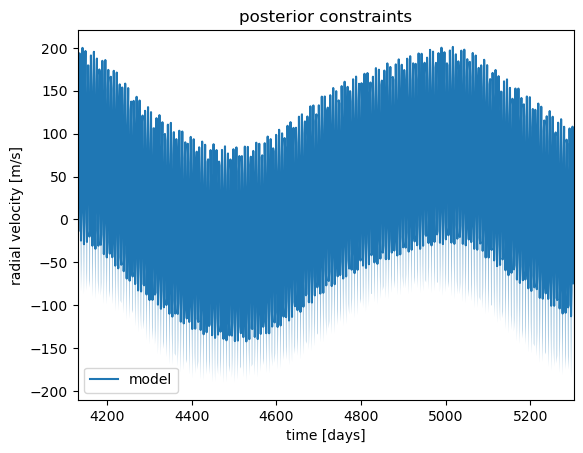

In [88]:
# plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[2], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.5)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

In [89]:
# rv_pred = trace.posterior["rv_model_pred"].values
# print(rv_pred)
# # plt.plot(t, rv_pred[3])


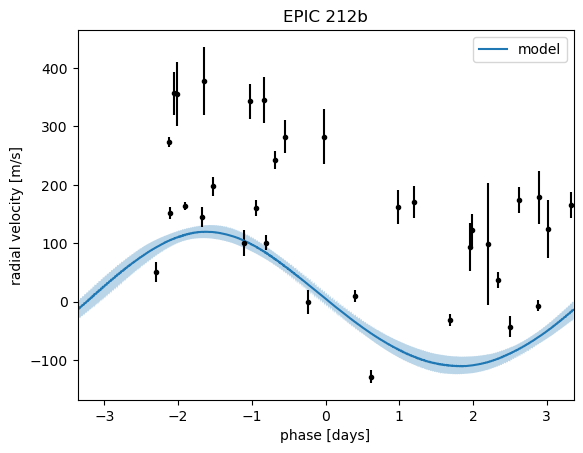

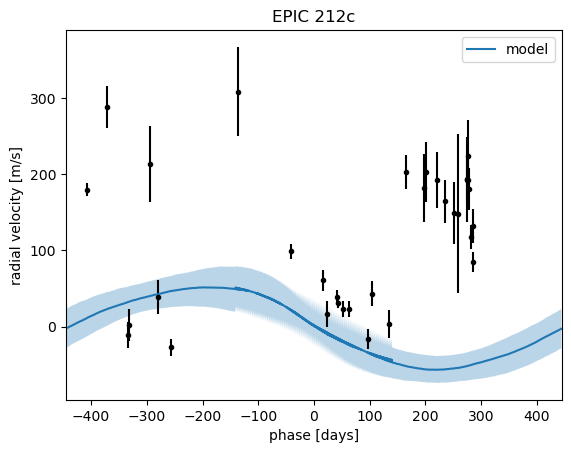

In [87]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["period"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )
    #other += np.median(trace.posterior["bkg"].values, axis=(0, 1))

    # Plot the folded data
    x_fold = (time - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, rad_vel - other, yerr = rv_err, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("EPIC 212{0}".format(letter))

In [17]:
# Add gamma-offset